In [17]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import pandas as pd
import matplotlib.pyplot as plt
from torchmetrics import Accuracy, F1Score, Recall, Precision, ConfusionMatrix
import requests
from pathlib import Path
from timeit import default_timer as timer
from tqdm.auto import tqdm
print(torch.__version__)
print(torchvision.__version__)
from helper_functions import print_train_time
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

2.8.0
0.23.0


In [2]:
train_transform = transforms.Compose([
    transforms.RandomCrop(28, padding=2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

#Setup training data
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=train_transform,
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [ ]:
class_names = train_data.classes

NUM_CLASSES = len(class_names)
#Setup the batch size hyperparameter
BATCH_SIZE = 32


In [4]:

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

Text(0.5, 1.0, '9')

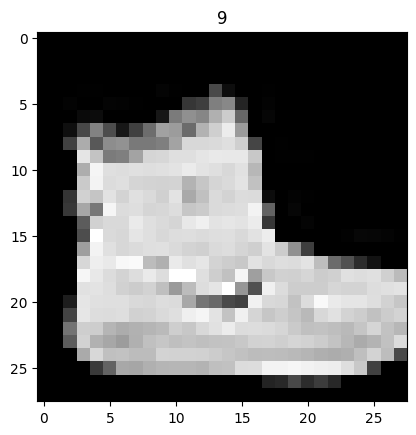

In [5]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(label)

In [6]:
image.shape

torch.Size([1, 28, 28])

In [7]:
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")


In [8]:
#Training func
def train_step(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device | str = 'cpu',
               task: str = "multiclass",
               num_classes = None,
               scheduler: torch.optim.lr_scheduler._LRScheduler | None  = None) -> tuple:
    """Performs a training with model trying to learn on data_loader"""
    #Creating training and test loop
    model.train()
    acc_metric = Accuracy(task=task, num_classes=num_classes).to(device)
    total_loss, total_n  = 0, 0

    # initializing from optimizer before any steps
    current_lr = optimizer.param_groups[0]["lr"]

    for X, y in tqdm(data_loader):
        X, y = X.to(device), y.to(device)
        #1. Forward pass
        logits = model(X)

        #2. Calculate loss (per batch)
        batch_loss = loss_fn(logits, y)

        #Calc total loss and n(number of sample(batch))
        n = y.size(0)
        total_loss += batch_loss.item() * n # accumulate train loss
        total_n += n

        #acc
        acc_metric.update(logits, y)

        #3 three steps
        optimizer.zero_grad(set_to_none=True); batch_loss.backward(); optimizer.step()


        if scheduler is not None:
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]



    # Scale loss and acc to find the average loss/acc per batch
    avg_loss = total_loss / total_n
    avg_acc = acc_metric.compute().item()
    print(f"Train loss: {avg_loss:.5f} | Train accuracy: {avg_acc * 100:.2f}% | lr: {current_lr}")
    return avg_loss, avg_acc


In [9]:
#Testing func
def test_step(model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              device: torch.device | str = "cpu",
              task: str = "multiclass",
              num_classes = None) -> tuple:
    """Returns a tuple that contains avg_loss, avg_acc"""
    acc_metric = Accuracy(task=task, num_classes=num_classes).to(device)

    total_loss = 0.0
    total_n = 0

    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)

            # Make predictions
            logits = model(X)
            batch_loss = loss_fn(logits, y)

            n = y.size(0)
            total_loss += batch_loss.item() * n
            total_n += n

            acc_metric.update(logits, y)
    # Scale loss and acc to find the average loss/acc per batch
    avg_loss = total_loss / total_n
    avg_acc = acc_metric.compute().item()
    print(f"Test loss: {avg_loss:.5f} | Test accuracy: {avg_acc * 100:.2f}%")
    return avg_loss, avg_acc

### Model 2: Builing a Convolutional NN 

In [10]:

class FashionMNISTModelV2(nn.Module):
    """
    TinyVGG-style CNN for 28x28 Fashion-MNIST.
    Uses a dummy forward pass in __init__ to infer Linear in_features.
    """
    def __init__(self, input_shade: int,
                 hidden_units: int,
                 output_shape: int,
                 image_size: int = 28):
        super().__init__()
        self.image_size = image_size

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shade, hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)  # 28->14
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)  # 14->7
        )

        # --- dummy part: infer flattened features to accelerate/avoid shape bugs ---
        with torch.inference_mode():
            dummy = torch.zeros(1, input_shade, image_size, image_size)
            feat = self.conv_block_2(self.conv_block_1(dummy))
            flattened = feat.numel()  # batch=1 so this is channels*H*W

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened, hidden_units),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)   # <- removed stray comma that made a tuple
        x = self.classifier(x)
        return x


In [11]:
torch.manual_seed(42)
model_2  = FashionMNISTModelV2(input_shade=1,
                               hidden_units=10,
                               output_shape=NUM_CLASSES).to(device)

In [12]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_2.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-3,                       # try 2e-3 .. 5e-3
    epochs=20,                         # total planned epochs
    steps_per_epoch=len(train_dataloader),
    pct_start=0.3,                     # warmup fraction
    div_factor=10,                     # initial lr = max_lr/10
    final_div_factor=10                # final lr = max_lr/100
)

In [ ]:
def train_test_loop(history: list,
                    model: nn.Module,
                    train_data_loader: torch.utils.data.DataLoader,
                    test_data_loader: torch.utils.data.DataLoader,
                    loss_fn: nn.Module,
                    optimizer: torch.optim.Optimizer,
                    device: torch.device | str = 'cpu',
                    num_classes: int = 10 ,
                    scheduler: torch.optim.lr_scheduler._LRScheduler | None  = None,
                    epochs: int = 10,
                    timer_fn=timer,
                    log_path: str | None | Path = None):
    
    path = Path(log_path) if log_path is not None else Path("csv/history_model.csv")
    path.parent.mkdir(parents=True, exist_ok=True)
    cols = ["epoch", "train_loss", "train_acc", "val_loss", "val_acc", "lr", "elapsed_s"]

    t0 = timer_fn()
    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}\n-------" )

        train_loss, train_acc = train_step(model=model,
                                       data_loader=train_data_loader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device,
                                       num_classes=num_classes,
                                       scheduler=scheduler)
        test_loss, test_acc = test_step(model=model,
                                    loss_fn=loss_fn,
                                    data_loader=test_data_loader,
                                    device=device,
                                    num_classes=num_classes)
        
        if scheduler is not None:
            lr = scheduler.get_last_lr()[0]
        else:
            lr = optimizer.param_groups[0]["lr"]
            
        row = {
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc":  train_acc,
            "val_loss":   test_loss,
            "val_acc":    test_acc,
            "lr":         lr,
            "elapsed_s":  timer_fn() - t0
        }
        history.append(row)

        pd.DataFrame([row], columns=cols).to_csv(
            path,
            sep= ",",
            mode="a",
            header=not path.exists(),
            index=False
        )
        

    print(f"Training finished in {timer_fn() - t0:.2f}s. "
      f"Logs saved to: {log_path if log_path else {path}}")
    return history

In [14]:
"""from pathlib import Path

# --- Training Loop ---
history = []
epochs = 20
train_start_time = timer()

# Create directory for saving results
Path("csv").mkdir(parents=True, exist_ok=True)

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch + 1}\n-------" )
    train_loss, train_acc = train_step(model=model_2,
                                       data_loader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device,
                                       num_classes=NUM_CLASSES,
                                       scheduler=scheduler)

    test_loss, test_acc = test_step(model=model_2,
                                    loss_fn=loss_fn,
                                    data_loader=test_dataloader,
                                    device=device,
                                    num_classes=NUM_CLASSES)

    lr = optimizer.param_groups[0]['lr']
    history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc":  train_acc,
            "val_loss":   test_loss,
            "val_acc":    test_acc,
            "lr":         lr,
            "elapsed_s":  timer() - train_start_time
        })
"""


'from pathlib import Path\n\n# --- Training Loop ---\nhistory = []\nepochs = 20\ntrain_start_time = timer()\n\n# Create directory for saving results\nPath("csv").mkdir(parents=True, exist_ok=True)\n\nfor epoch in tqdm(range(epochs)):\n    print(f"Epoch: {epoch + 1}\n-------" )\n    train_loss, train_acc = train_step(model=model_2,\n                                       data_loader=train_dataloader,\n                                       loss_fn=loss_fn,\n                                       optimizer=optimizer,\n                                       device=device,\n                                       num_classes=NUM_CLASSES,\n                                       scheduler=scheduler)\n\n    test_loss, test_acc = test_step(model=model_2,\n                                    loss_fn=loss_fn,\n                                    data_loader=test_dataloader,\n                                    device=device,\n                                    num_classes=NUM_CLASSES)\n\n    lr 

In [18]:
@torch.inference_mode()
def collecting_preds(model: nn.Module,
                     data_loader: torch.utils.data.DataLoader,
                     device: torch.device):
    model.eval()
    y_trues, y_preds = [], []
    for X, y in data_loader:
        X = X.to(device); y = y.to(device)
        logits = model(X)
        preds = logits.argmax(dim=1)
        y_trues.append(y.cpu())
        y_preds.append(preds.cpu())
    y_trues = torch.cat(y_trues)
    y_preds = torch.cat(y_preds)

    return y_trues, y_preds




In [15]:
# Convert history to DataFrame and save
history = []
epochs = 20


hist_df = pd.DataFrame(train_test_loop(
    history=history,
    model=model_2,
    train_data_loader=train_dataloader,
    test_data_loader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    num_classes=NUM_CLASSES,
    epochs=epochs,
    scheduler=scheduler
))
print(hist_df.tail(3))           # quick sanity check
hist_df.to_csv("csv/history_model3.csv", index=False)

Epoch: 1
-------


  0%|          | 0/1875 [00:00<?, ?it/s]

100%|██████████| 1875/1875 [00:08<00:00, 214.46it/s]


Train loss: 1.17494 | Train accuracy: 56.33% | lr: 0.00048089712487680344


100%|██████████| 313/313 [00:00<00:00, 527.52it/s]


Test loss: 0.81513 | Test accuracy: 69.12%
Epoch: 2
-------


100%|██████████| 1875/1875 [00:08<00:00, 219.35it/s]


Train loss: 0.76599 | Train accuracy: 71.65% | lr: 0.0009751088405610007


100%|██████████| 313/313 [00:00<00:00, 537.60it/s]


Test loss: 0.64848 | Test accuracy: 76.37%
Epoch: 3
-------


100%|██████████| 1875/1875 [00:08<00:00, 215.86it/s]


Train loss: 0.67330 | Train accuracy: 74.51% | lr: 0.001650188512315253


100%|██████████| 313/313 [00:00<00:00, 500.31it/s]


Test loss: 0.63413 | Test accuracy: 77.08%
Epoch: 4
-------


100%|██████████| 1875/1875 [00:08<00:00, 212.37it/s]


Train loss: 0.60303 | Train accuracy: 77.15% | lr: 0.0023252176635719752


100%|██████████| 313/313 [00:00<00:00, 549.77it/s]


Test loss: 0.52701 | Test accuracy: 80.69%
Epoch: 5
-------


100%|██████████| 1875/1875 [00:08<00:00, 210.71it/s]


Train loss: 0.55129 | Train accuracy: 79.36% | lr: 0.0028192913570417293


100%|██████████| 313/313 [00:00<00:00, 517.32it/s]


Test loss: 0.46001 | Test accuracy: 83.01%
Epoch: 6
-------


100%|██████████| 1875/1875 [00:09<00:00, 202.33it/s]


Train loss: 0.49992 | Train accuracy: 81.38% | lr: 0.0029999999893649976


100%|██████████| 313/313 [00:00<00:00, 511.18it/s]


Test loss: 0.46547 | Test accuracy: 82.68%
Epoch: 7
-------


100%|██████████| 1875/1875 [00:09<00:00, 207.16it/s]


Train loss: 0.46526 | Train accuracy: 82.90% | lr: 0.0029627283918257376


100%|██████████| 313/313 [00:00<00:00, 526.09it/s]


Test loss: 0.42645 | Test accuracy: 84.68%
Epoch: 8
-------


100%|██████████| 1875/1875 [00:08<00:00, 213.06it/s]


Train loss: 0.44404 | Train accuracy: 83.69% | lr: 0.0028528616475330336


100%|██████████| 313/313 [00:00<00:00, 507.75it/s]


Test loss: 0.39235 | Test accuracy: 85.71%
Epoch: 9
-------


100%|██████████| 1875/1875 [00:08<00:00, 210.12it/s]


Train loss: 0.42336 | Train accuracy: 84.50% | lr: 0.0026759089338092923


100%|██████████| 313/313 [00:00<00:00, 503.97it/s]


Test loss: 0.38438 | Test accuracy: 86.03%
Epoch: 10
-------


100%|██████████| 1875/1875 [00:08<00:00, 212.30it/s]


Train loss: 0.40688 | Train accuracy: 84.97% | lr: 0.002440743398610807


100%|██████████| 313/313 [00:00<00:00, 531.30it/s]


Test loss: 0.37231 | Test accuracy: 86.84%
Epoch: 11
-------


100%|██████████| 1875/1875 [00:08<00:00, 210.68it/s]


Train loss: 0.39467 | Train accuracy: 85.63% | lr: 0.0021591572238381872


100%|██████████| 313/313 [00:00<00:00, 525.24it/s]


Test loss: 0.35820 | Test accuracy: 87.05%
Epoch: 12
-------


100%|██████████| 1875/1875 [00:08<00:00, 209.97it/s]


Train loss: 0.38239 | Train accuracy: 86.07% | lr: 0.001845270316096


100%|██████████| 313/313 [00:00<00:00, 515.78it/s]


Test loss: 0.34426 | Test accuracy: 87.73%
Epoch: 13
-------


100%|██████████| 1875/1875 [00:08<00:00, 211.89it/s]


Train loss: 0.36624 | Train accuracy: 86.69% | lr: 0.0015148222756160212


100%|██████████| 313/313 [00:00<00:00, 554.04it/s]


Test loss: 0.33936 | Test accuracy: 87.81%
Epoch: 14
-------


100%|██████████| 1875/1875 [00:08<00:00, 208.74it/s]


Train loss: 0.35525 | Train accuracy: 87.10% | lr: 0.0011843831469787675


100%|██████████| 313/313 [00:00<00:00, 552.07it/s]


Test loss: 0.33212 | Test accuracy: 88.28%
Epoch: 15
-------


100%|██████████| 1875/1875 [00:08<00:00, 212.90it/s]


Train loss: 0.34691 | Train accuracy: 87.43% | lr: 0.0008705225278877486


100%|██████████| 313/313 [00:00<00:00, 547.51it/s]


Test loss: 0.32095 | Test accuracy: 88.43%
Epoch: 16
-------


100%|██████████| 1875/1875 [00:08<00:00, 211.93it/s]


Train loss: 0.33708 | Train accuracy: 87.85% | lr: 0.0005889787003519998


100%|██████████| 313/313 [00:00<00:00, 548.74it/s]


Test loss: 0.31943 | Test accuracy: 88.58%
Epoch: 17
-------


100%|██████████| 1875/1875 [00:09<00:00, 204.78it/s]


Train loss: 0.32976 | Train accuracy: 88.02% | lr: 0.0003538694475088029


100%|██████████| 313/313 [00:00<00:00, 518.17it/s]


Test loss: 0.31404 | Test accuracy: 88.73%
Epoch: 18
-------


100%|██████████| 1875/1875 [00:08<00:00, 211.53it/s]


Train loss: 0.32329 | Train accuracy: 88.25% | lr: 0.00017698412902646045


100%|██████████| 313/313 [00:00<00:00, 534.24it/s]


Test loss: 0.30766 | Test accuracy: 89.14%
Epoch: 19
-------


100%|██████████| 1875/1875 [00:09<00:00, 206.81it/s]


Train loss: 0.32083 | Train accuracy: 88.29% | lr: 6.719251338244275e-05


100%|██████████| 313/313 [00:00<00:00, 544.10it/s]


Test loss: 0.30788 | Test accuracy: 89.09%
Epoch: 20
-------


100%|██████████| 1875/1875 [00:09<00:00, 207.00it/s]


Train loss: 0.31682 | Train accuracy: 88.49% | lr: 3.0000010635002354e-05


100%|██████████| 313/313 [00:00<00:00, 526.04it/s]

Test loss: 0.30642 | Test accuracy: 89.14%
Training finished in 190.07s. Logs saved to: no log file
    epoch  train_loss  train_acc  val_loss  val_acc        lr   elapsed_s
17     18    0.323294   0.882533  0.307660   0.8914  0.000177  170.762753
18     19    0.320832   0.882933  0.307885   0.8909  0.000067  180.412727
19     20    0.316818   0.884850  0.306423   0.8914  0.000030  190.074048


In [20]:
y_true, y_pred = collecting_preds(model=model_2,
                                  data_loader=test_dataloader,
                                  device=device)
cm = confusion_matrix(y_true=y_true,
                      y_pred=y_pred,
                      labels=range(NUM_CLASSES),
                      )
per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)
print("Per-class accuracy:")
for i, acc in enumerate(per_class_acc):
    print(f"{i:>2} {class_names[i]:<12}: {acc*100:5.1f}%")

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

Per-class accuracy:
 0 T-shirt/top :  85.0%
 1 Trouser     :  97.5%
 2 Pullover    :  82.2%
 3 Dress       :  90.5%
 4 Coat        :  87.7%
 5 Sandal      :  95.8%
 6 Shirt       :  64.2%
 7 Sneaker     :  95.8%
 8 Bag         :  96.6%
 9 Ankle boot  :  96.1%

Classification report:
              precision    recall  f1-score   support

 T-shirt/top      0.842     0.850     0.846      1000
     Trouser      0.988     0.975     0.981      1000
    Pullover      0.862     0.822     0.841      1000
       Dress      0.879     0.905     0.892      1000
        Coat      0.778     0.877     0.825      1000
      Sandal      0.981     0.958     0.969      1000
       Shirt      0.723     0.642     0.680      1000
     Sneaker      0.938     0.958     0.948      1000
         Bag      0.967     0.966     0.966      1000
  Ankle boot      0.954     0.961     0.958      1000

    accuracy                          0.891     10000
   macro avg      0.891     0.891     0.891     10000
weighted avg